In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Dataframe") \
    .config("spark.driver.extraClassPath", "/usr/local/spark-3.3.1-bin-hadoop3/jars") \
    .getOrCreate()

sc = spark.sparkContext

#### text 형태의 데이터를 전처리해서 csv 형태로 저장해보자!
(부제: 엔지니어링 A조 MBTI 살펴보기)

- raw_data 생성

In [2]:
raw_data = ["윤건우, ISTP, 24; \
            이가람, ESTJ, 23; \
            이선의, null, null; \
            이수민, ESTP, null; \
            채영대, null, null; \
            이상암, ENTJ, null; \
            유하준, ESTJ, secret; \
            정태형, ESFJ, null; \
            최윤서, INTJ, 24"]

- RDD로 변환

In [3]:
RDD_data = sc.parallelize(raw_data)
RDD_data.collect()

['윤건우, ISTP, 24;             이가람, ESTJ, 23;             이선의, null, null;             이수민, ESTP, null;             채영대, null, null;             이상암, ENTJ, null;             유하준, ESTJ, secret;             정태형, ESFJ, null;             최윤서, INTJ, 24']

- flatMap() 함수를 이용하여 데이터 전처리

In [4]:
RDD_split_data = RDD_data.flatMap(lambda x : x.split(';'))

In [5]:
RDD_split_data.collect()

['윤건우, ISTP, 24',
 '             이가람, ESTJ, 23',
 '             이선의, null, null',
 '             이수민, ESTP, null',
 '             채영대, null, null',
 '             이상암, ENTJ, null',
 '             유하준, ESTJ, secret',
 '             정태형, ESFJ, null',
 '             최윤서, INTJ, 24']

- 등등의 로직을 이용하여 남은 전처리

In [6]:
# Split data and create Row objects
def parse_data(row):
    parts = row.strip().split(", ")
    name = parts[0]
    _type = parts[1] if parts[1] != "null" else None
    age = parts[2] if parts[2] != "null" else None
    return [name, _type, age]

In [7]:
RDD_clear_data = RDD_split_data.map(parse_data)
RDD_clear_data.collect()

[['윤건우', 'ISTP', '24'],
 ['이가람', 'ESTJ', '23'],
 ['이선의', None, None],
 ['이수민', 'ESTP', None],
 ['채영대', None, None],
 ['이상암', 'ENTJ', None],
 ['유하준', 'ESTJ', 'secret'],
 ['정태형', 'ESFJ', None],
 ['최윤서', 'INTJ', '24']]

- Dataframe 형태로 변환

In [8]:
# RDD.toDF()를 이용하여 RDD를 Dataframe 형태로 변환할 수 있다.
DF_data = RDD_clear_data.toDF(["이름","MBTI","나이"])
DF_data

DataFrame[이름: string, MBTI: string, 나이: string]

In [9]:
DF_data.collect()

[Row(이름='윤건우', MBTI='ISTP', 나이='24'),
 Row(이름='이가람', MBTI='ESTJ', 나이='23'),
 Row(이름='이선의', MBTI=None, 나이=None),
 Row(이름='이수민', MBTI='ESTP', 나이=None),
 Row(이름='채영대', MBTI=None, 나이=None),
 Row(이름='이상암', MBTI='ENTJ', 나이=None),
 Row(이름='유하준', MBTI='ESTJ', 나이='secret'),
 Row(이름='정태형', MBTI='ESFJ', 나이=None),
 Row(이름='최윤서', MBTI='INTJ', 나이='24')]

In [10]:
DF_data.show() # show()를 이용해서도 데이터를 볼 수 있다. (action)

+------+----+------+
|  이름|MBTI|  나이|
+------+----+------+
|윤건우|ISTP|    24|
|이가람|ESTJ|    23|
|이선의|null|  null|
|이수민|ESTP|  null|
|채영대|null|  null|
|이상암|ENTJ|  null|
|유하준|ESTJ|secret|
|정태형|ESFJ|  null|
|최윤서|INTJ|    24|
+------+----+------+



In [11]:
type(DF_data)

pyspark.sql.dataframe.DataFrame

- MBTI가 null이 아닌 데이터만 추출

In [12]:
DF_not_null = DF_data.filter(DF_data["MBTI"].isNotNull())
DF_not_null.show()

+------+----+------+
|  이름|MBTI|  나이|
+------+----+------+
|윤건우|ISTP|    24|
|이가람|ESTJ|    23|
|이수민|ESTP|  null|
|이상암|ENTJ|  null|
|유하준|ESTJ|secret|
|정태형|ESFJ|  null|
|최윤서|INTJ|    24|
+------+----+------+



- MBTI 열을 이용하여 새로운 열 생성

In [13]:
from pyspark.sql.functions import col

new_DF = DF_not_null\
            .withColumn("EorI", col("MBTI").substr(1, 1)) \
            .withColumn("NorS", col("MBTI").substr(2, 1)) \
            .withColumn("ForT", col("MBTI").substr(3, 1)) \
            .withColumn("JorP", col("MBTI").substr(4, 1))

In [14]:
new_DF.show()

+------+----+------+----+----+----+----+
|  이름|MBTI|  나이|EorI|NorS|ForT|JorP|
+------+----+------+----+----+----+----+
|윤건우|ISTP|    24|   I|   S|   T|   P|
|이가람|ESTJ|    23|   E|   S|   T|   J|
|이수민|ESTP|  null|   E|   S|   T|   P|
|이상암|ENTJ|  null|   E|   N|   T|   J|
|유하준|ESTJ|secret|   E|   S|   T|   J|
|정태형|ESFJ|  null|   E|   S|   F|   J|
|최윤서|INTJ|    24|   I|   N|   T|   J|
+------+----+------+----+----+----+----+



- 그래프 그려보기

In [15]:
import matplotlib.pyplot as plt

In [16]:
# 각 요소별 분포 데이터 추출
mbti1 = new_DF.groupBy("EorI").count().collect()
mbti2 = new_DF.groupBy("NorS").count().collect()
mbti3 = new_DF.groupBy("ForT").count().collect()
mbti4 = new_DF.groupBy("JorP").count().collect()

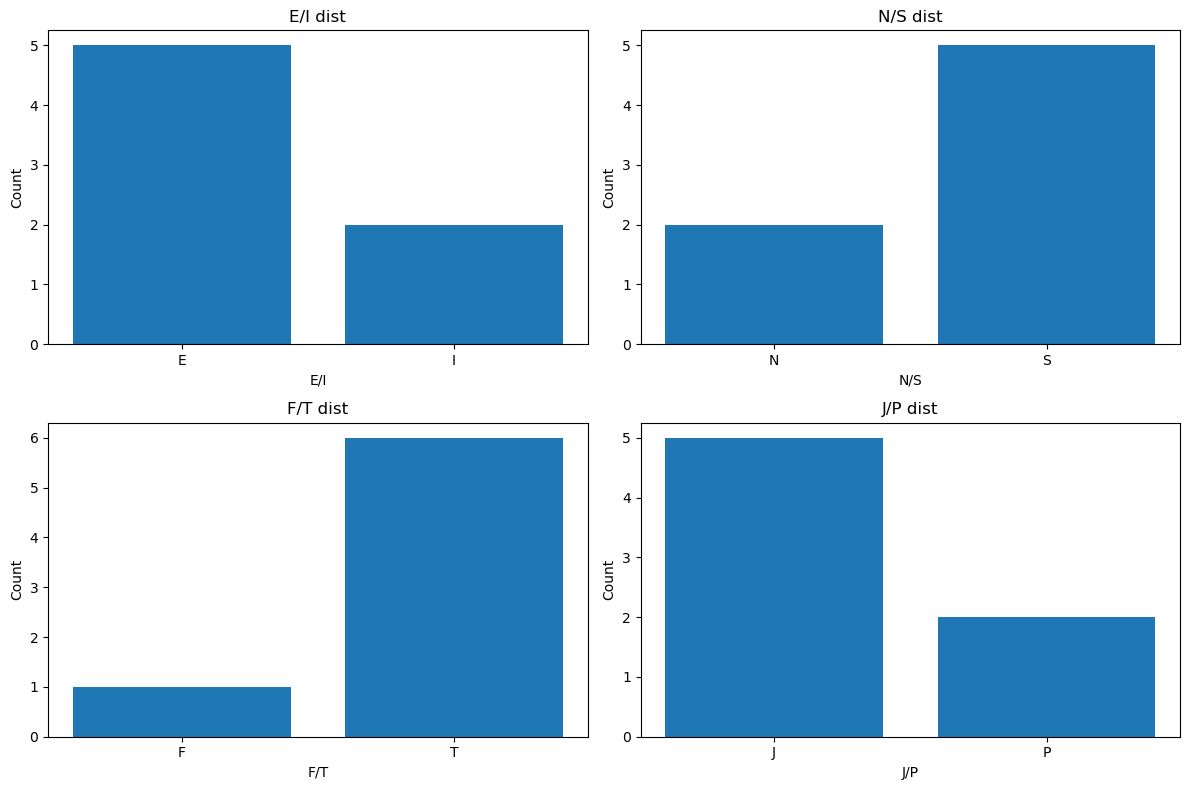

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.bar([row["EorI"] for row in mbti1], [row["count"] for row in mbti1])
plt.xlabel("E/I")
plt.ylabel("Count")
plt.title("E/I dist")

plt.subplot(2, 2, 2)
plt.bar([row["NorS"] for row in mbti2], [row["count"] for row in mbti2])
plt.xlabel("N/S")
plt.ylabel("Count")
plt.title("N/S dist")

plt.subplot(2, 2, 3)
plt.bar([row["ForT"] for row in mbti3], [row["count"] for row in mbti3])
plt.xlabel("F/T")
plt.ylabel("Count")
plt.title("F/T dist")

plt.subplot(2, 2, 4)
plt.bar([row["JorP"] for row in mbti4], [row["count"] for row in mbti4])
plt.xlabel("J/P")
plt.ylabel("Count")
plt.title("J/P dist")

plt.tight_layout()
plt.show()

- postgreSQL에 저장

In [20]:
database_url = "jdbc:postgresql://postgres:5432/boaz"
database_properties = {
    "user": "boaz",
    "password": "boaz",
    "driver": "org.postgresql.Driver"
}

new_DF.write.jdbc(url=database_url, table="boaz_engin_A", mode="overwrite", properties=database_properties)

In [ ]:
# spark 세션 종료
spark.stop()